<a href="https://colab.research.google.com/github/Onkar2506/Email-Merge/blob/main/Satellite_Image_Classification_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Step 1: Importing all required packages and modules

In [3]:
import os
import cv2
import tensorflow
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, Xception, InceptionResNetV2, ResNet50V2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

Step 2: Data loading

In [4]:
data_dir = '/content/drive/MyDrive/data'

In [5]:
categories  = ['cloudy', 'desert', 'green_area', 'water']
data = []
data_labels = []

for categorie in categories :
    folder_path = os.path.join(data_dir, categorie)
    image_paths = os.listdir(folder_path)
    data.extend([os.path.join(folder_path, image_path) for image_path in image_paths])
    data_labels.extend([categorie] * len(image_paths))
data = pd.DataFrame({'Image_Path' : data, 'labels' : data_labels})
data

,Image_Path,labels
0,/content/drive/MyDrive/data/cloudy/train_2900.jpg,cloudy
1,/content/drive/MyDrive/data/cloudy/train_22809...,cloudy
2,/content/drive/MyDrive/data/cloudy/train_34951...,cloudy
3,/content/drive/MyDrive/data/cloudy/train_3096.jpg,cloudy
4,/content/drive/MyDrive/data/cloudy/train_37070...,cloudy
...,...,...
5716,/content/drive/MyDrive/data/water/SeaLake_53.jpg,water
5717,/content/drive/MyDrive/data/water/SeaLake_1470...,water
5718,/content/drive/MyDrive/data/water/SeaLake_2864...,water
5719,/content/drive/MyDrive/data/water/SeaLake_1305...,water


Step 3: Data visualization

Displaying Some Sample images of 'cloudy' categorie : 


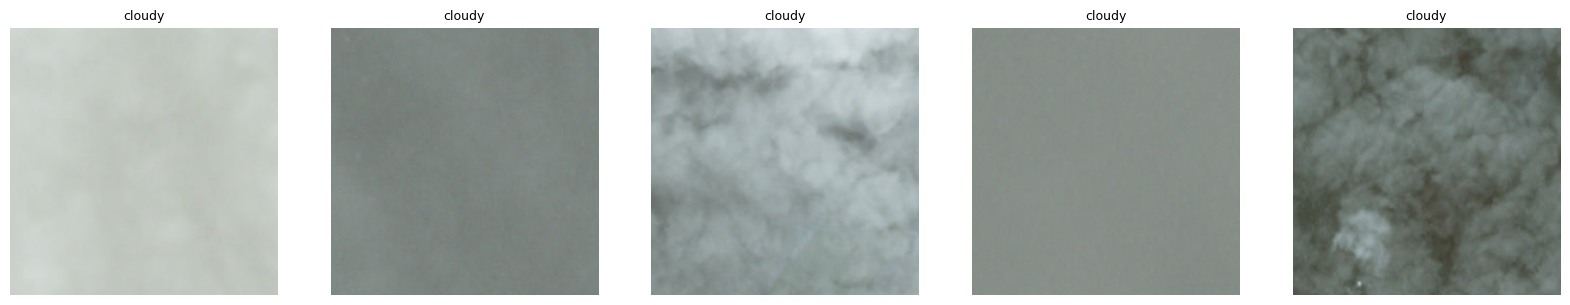

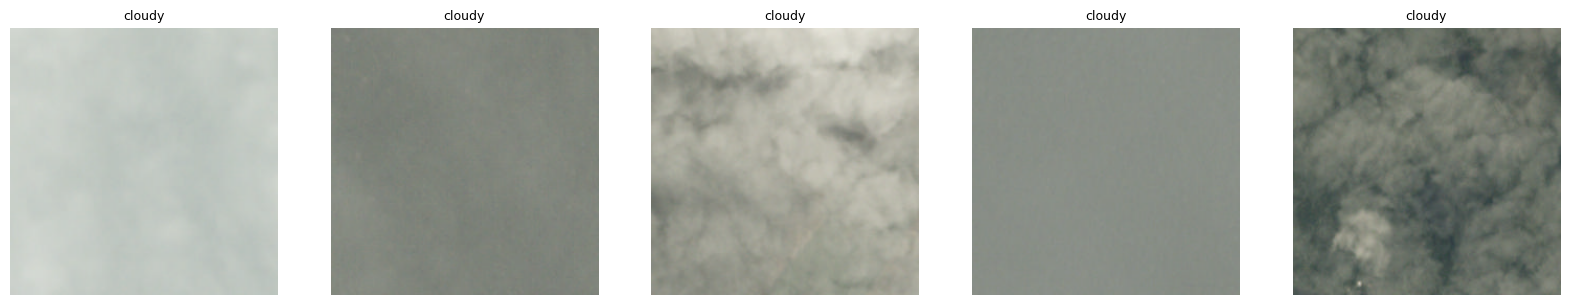

Displaying Some Sample images of 'desert' categorie : 


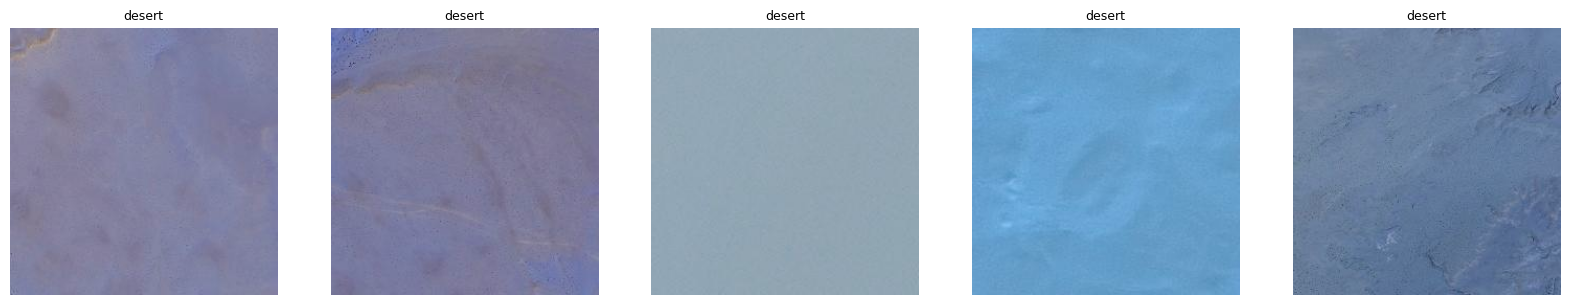

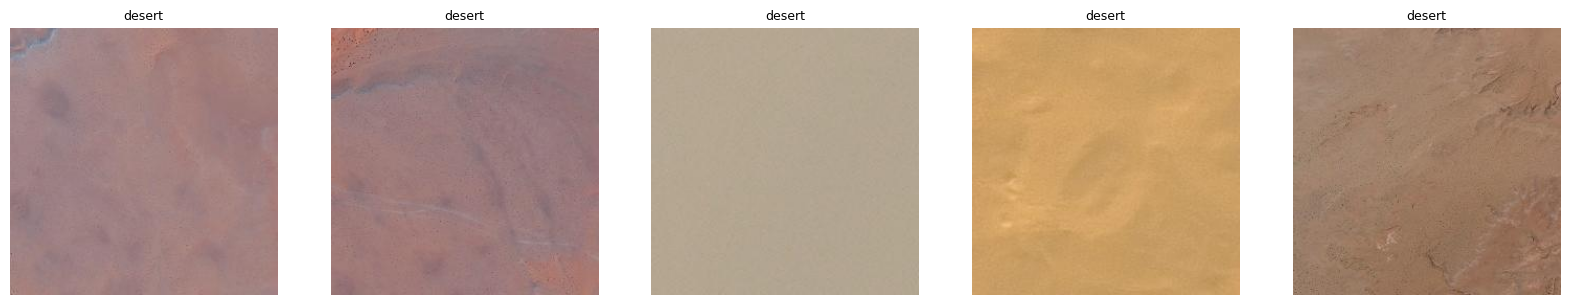

Displaying Some Sample images of 'green_area' categorie : 


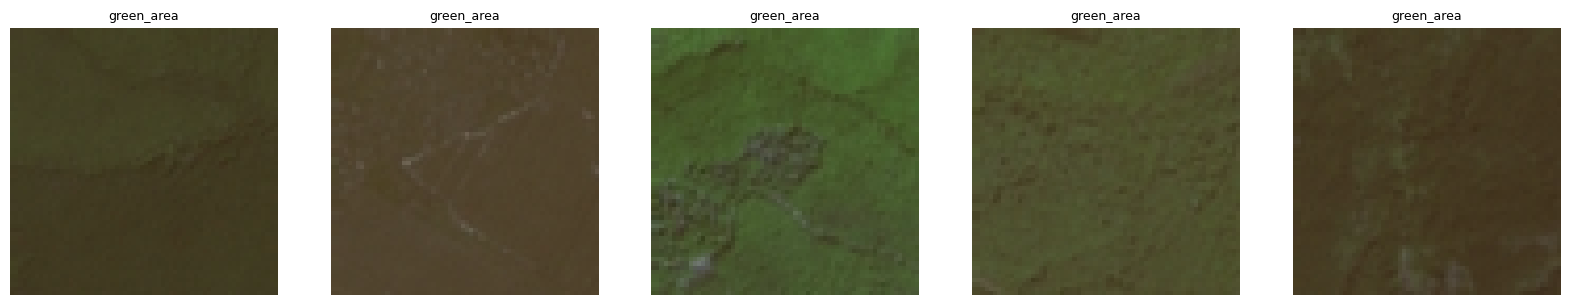

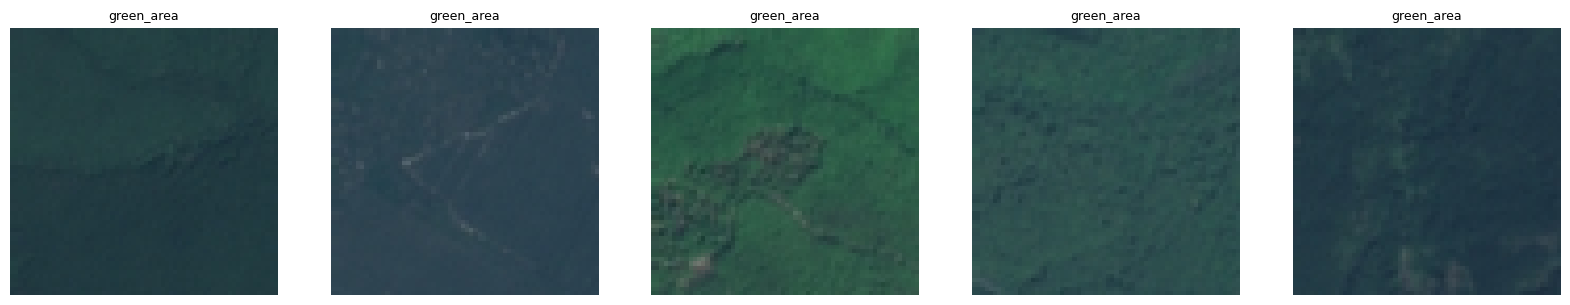

Displaying Some Sample images of 'water' categorie : 


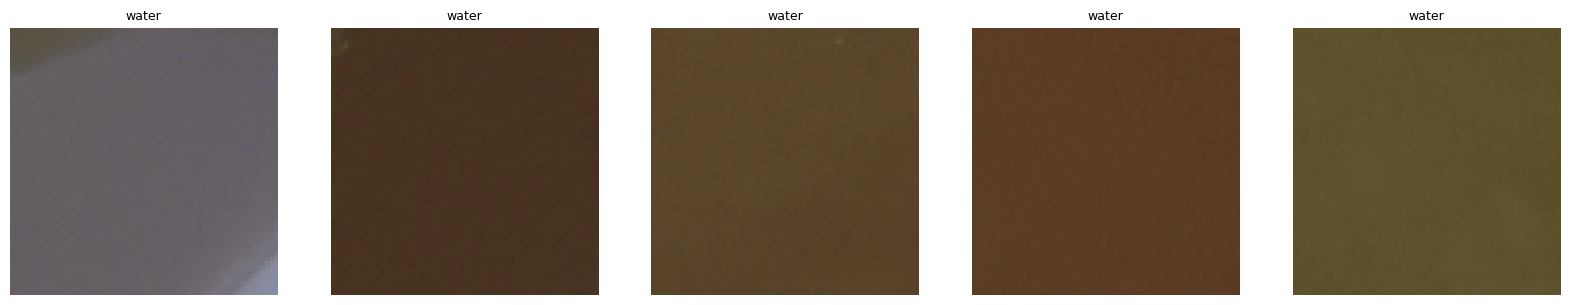

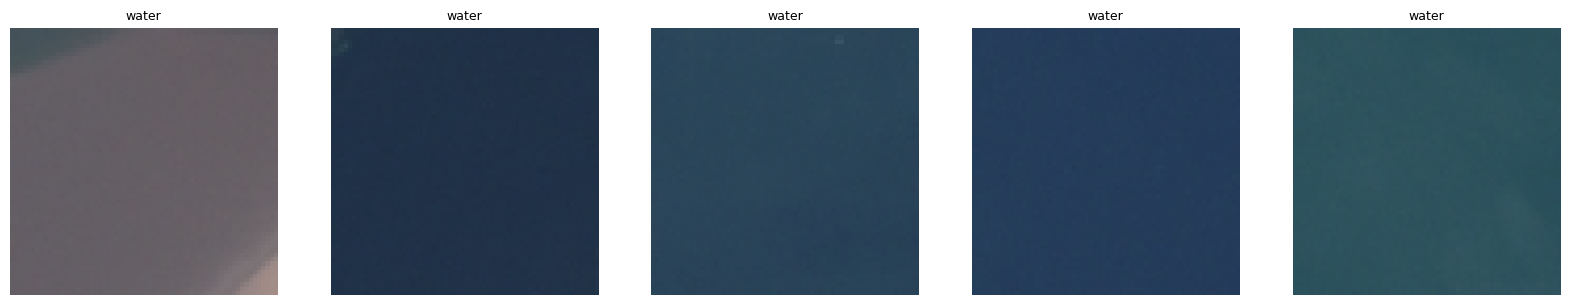

In [6]:
labels = ['cloudy', 'desert', 'green_area', 'water']

for label in labels:
    sample_images = data[data['labels'] == label]['Image_Path'].reset_index(drop=True)[:5]

    print(f"Displaying Some Sample images of '{label}' categorie : ")
    plt.figure(figsize=(20, 8))
    # Displaying Some Sample images in BGR
    for i in range(len(sample_images)):
        plt.subplot(2, 5, i + 1)
        img = cv2.imread(sample_images[i])
        plt.imshow(img)
        plt.title(label, fontsize=9)
        plt.axis('off')
    plt.show()
    # Displaying Some Sample images in RGB
    plt.figure(figsize=(20, 8))
    for i in range(len(sample_images)):
        plt.subplot(2, 5, i + 1 + 5)
        img = cv2.imread(sample_images[i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        plt.title(label, fontsize=9)
        plt.axis('off')

    plt.show()

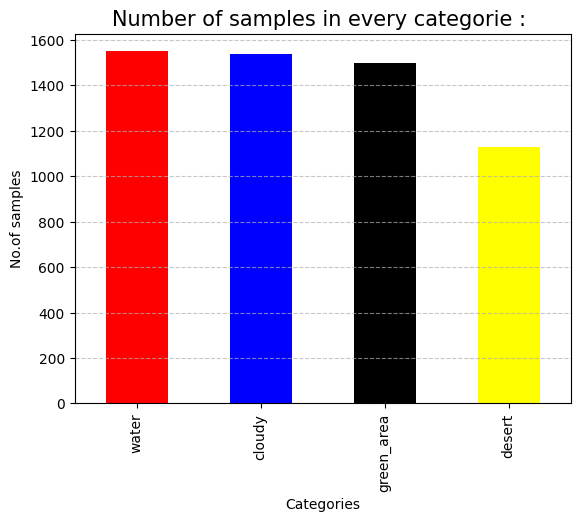

In [7]:
data['labels'].value_counts().plot(kind = 'bar', color = ['red', 'blue', 'black', 'yellow'])
plt.title('Number of samples in every categorie : ', fontsize = 15)
plt.xlabel('Categories')
plt.ylabel('No.of samples')
plt.grid(axis='y', linestyle='--', alpha=0.7)

Step 4: Data Pre-processing and Augmentation

In [8]:
datagen = ImageDataGenerator(
    rescale = 1./255,
    validation_split = 0.25,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.3,
    horizontal_flip = True,
    zoom_range = 0.2
)

In [9]:
# Training Data
train_data = datagen.flow_from_directory(
    data_dir,
    target_size=(75, 75),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Validation Data
val_data = datagen.flow_from_directory(
    data_dir,
    target_size=(75, 75),
    batch_size=1,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# Test Data (Separate folder or another 10% of data)
test_datagen = ImageDataGenerator(rescale=1./255)  # Only rescaling for test data
test_data = test_datagen.flow_from_directory(
    data_dir,
    target_size=(75, 75),
    batch_size=10,
    class_mode='categorical',
    shuffle=True
)

Found 4292 images belonging to 4 classes.
Found 1429 images belonging to 4 classes.
Found 5721 images belonging to 4 classes.


In [10]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_data.classes),
    y=train_data.classes
)
class_weights = dict(enumerate(class_weights))

Step 5: Building the models

In [11]:
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(75, 75, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [12]:
# Freeze the layers of the base model
for layer in vgg_model.layers:
    layer.trainable = False

# Add custom layers
x = vgg_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(train_data.num_classes, activation='softmax')(x)

# Create the model
model1 = Model(inputs = vgg_model.input, outputs=predictions)

In [13]:
InceptionResNetV2_model = InceptionResNetV2(include_top=False, weights="imagenet", input_shape=(75, 75, 3))

219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [14]:
# Freeze the layers of the base model
for layer in InceptionResNetV2_model.layers:
    layer.trainable = False

# Add custom layers
x = InceptionResNetV2_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(train_data.num_classes, activation='softmax')(x)

# Create the model
model2 = Model(inputs = InceptionResNetV2_model.input, outputs=predictions)

In [15]:
Xception_model = Xception(include_top=False, weights="imagenet", input_shape=(75,75,3))

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [16]:
# Freeze the layers of the base model
for layer in Xception_model.layers:
    layer.trainable = False

# Add custom layers
x = Xception_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(train_data.num_classes, activation='softmax')(x)

# Create the model
model3 = Model(inputs = Xception_model.input, outputs=predictions)

In [17]:
ResNet50V2_model = ResNet50V2(include_top=False, weights='imagenet', input_shape=(75,75,3))

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [18]:
# Freeze the layers of the base model
for layer in ResNet50V2_model.layers:
    layer.trainable = False

# Add custom layers
x = ResNet50V2_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(train_data.num_classes, activation='softmax')(x)

# Create the model
model4 = Model(inputs = ResNet50V2_model.input, outputs=predictions)


Step 6: Compiling and training models

In [19]:
# Compile the model
model1.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy']
            )

In [20]:
model2.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy']
            )

In [21]:
model3.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy']
            )

In [22]:
# EarlyStoping the model
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
# Learning Rate Decay
lrd = ReduceLROnPlateau(monitor = 'val_loss', patience = 5,verbose = 1,factor = 0.50, min_lr = 1e-10)

In [24]:
# Train the model1
mc1 = ModelCheckpoint('best_VGG16_Satellite_Image_Classification_Model.keras',monitor='val_loss', mode='min', save_best_only=True)
history = model1.fit(
    train_data,
    validation_data=val_data,
    epochs=25,
    class_weight=class_weights,
    callbacks=[es, mc1, lrd]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
135/135 ━━━━━━━━━━━━━━━━━━━━ 1558s 12s/step - accuracy: 0.5168 - loss: 1.1099 - val_accuracy: 0.8111 - val_loss: 0.5429 - learning_rate: 0.0010
Epoch 2/25
135/135 ━━━━━━━━━━━━━━━━━━━━ 34s 251ms/step - accuracy: 0.8516 - loss: 0.4783 - val_accuracy: 0.8621 - val_loss: 0.4033 - learning_rate: 0.0010
Epoch 3/25
135/135 ━━━━━━━━━━━━━━━━━━━━ 32s 236ms/step - accuracy: 0.8591 - loss: 0.3702 - val_accuracy: 0.8565 - val_loss: 0.3503 - learning_rate: 0.0010
Epoch 4/25
135/135 ━━━━━━━━━━━━━━━━━━━━ 33s 245ms/step - accuracy: 0.8949 - loss: 0.3011 - val_accuracy: 0.9223 - val_loss: 0.2709 - learning_rate: 0.0010
Epoch 5/25
135/135 ━━━━━━━━━━━━━━━━━━━━ 31s 229ms/step - accuracy: 0.9023 - loss: 0.2912 - val_accuracy: 0.8628 - val_loss: 0.3031 - learning_rate: 0.0010
Epoch 6/25
135/135 ━━━━━━━━━━━━━━━━━━━━ 44s 257ms/step - accuracy: 0.9063 - loss: 0.2488 - val_accuracy: 0.9293 - val_loss: 0.2229 - learning_rate: 0.0010
Epoch 7/25
135/135 ━━━━━━━━━━━━━━━━━━━━ 45s 334ms/step - accuracy: 0.9

In [37]:
# Train the model
mc2 = ModelCheckpoint('best_InceptionResNetV2_Satellite_Image_Classification_Model.keras',monitor='val_loss', mode='min', save_best_only=True)
history = model2.fit(
    train_data,
    validation_data=val_data,
    epochs=25,
    class_weight=class_weights,
    callbacks=[es, mc2, lrd]
)

Epoch 1/25
135/135 ━━━━━━━━━━━━━━━━━━━━ 89s 448ms/step - accuracy: 0.4405 - loss: 4.7871 - val_accuracy: 0.5283 - val_loss: 1.7816 - learning_rate: 0.0010
Epoch 2/25
135/135 ━━━━━━━━━━━━━━━━━━━━ 52s 389ms/step - accuracy: 0.4985 - loss: 2.0173 - val_accuracy: 0.5066 - val_loss: 1.0659 - learning_rate: 0.0010
Epoch 3/25
135/135 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.5177 - loss: 1.4192 - val_accuracy: 0.5654 - val_loss: 1.4266 - learning_rate: 0.0010
Epoch 4/25
135/135 ━━━━━━━━━━━━━━━━━━━━ 50s 373ms/step - accuracy: 0.5420 - loss: 1.7408 - val_accuracy: 0.5388 - val_loss: 1.1419 - learning_rate: 0.0010
Epoch 5/25
135/135 ━━━━━━━━━━━━━━━━━━━━ 50s 371ms/step - accuracy: 0.5615 - loss: 1.6127 - val_accuracy: 0.5899 - val_loss: 1.0811 - learning_rate: 0.0010
Epoch 6/25
135/135 ━━━━━━━━━━━━━━━━━━━━ 50s 371ms/step - accuracy: 0.5508 - loss: 1.2012 - val_accuracy: 0.4906 - val_loss: 1.1112 - learning_rate: 0.0010
Epoch 7/25
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.54

In [38]:
# Train the model
mc3 = ModelCheckpoint('best_Xception_Satellite_Image_Classification_Model.keras',monitor='val_loss', mode='min', save_best_only=True)
history = model3.fit(
    train_data,
    validation_data=val_data,
    epochs=15,
    class_weight=class_weights,
    callbacks=[es, mc3, lrd]
)


Epoch 1/15
135/135 ━━━━━━━━━━━━━━━━━━━━ 44s 267ms/step - accuracy: 0.5527 - loss: 1.1593 - val_accuracy: 0.6900 - val_loss: 0.7797 - learning_rate: 0.0010
Epoch 2/15
135/135 ━━━━━━━━━━━━━━━━━━━━ 44s 314ms/step - accuracy: 0.6751 - loss: 0.8163 - val_accuracy: 0.7264 - val_loss: 0.6712 - learning_rate: 0.0010
Epoch 3/15
135/135 ━━━━━━━━━━━━━━━━━━━━ 72s 240ms/step - accuracy: 0.7470 - loss: 0.6932 - val_accuracy: 0.7831 - val_loss: 0.7389 - learning_rate: 0.0010
Epoch 4/15
135/135 ━━━━━━━━━━━━━━━━━━━━ 32s 239ms/step - accuracy: 0.7784 - loss: 0.6320 - val_accuracy: 0.8083 - val_loss: 0.5532 - learning_rate: 0.0010
Epoch 5/15
135/135 ━━━━━━━━━━━━━━━━━━━━ 42s 247ms/step - accuracy: 0.8089 - loss: 0.5623 - val_accuracy: 0.8188 - val_loss: 0.5285 - learning_rate: 0.0010
Epoch 6/15
135/135 ━━━━━━━━━━━━━━━━━━━━ 42s 311ms/step - accuracy: 0.8169 - loss: 0.4961 - val_accuracy: 0.8425 - val_loss: 0.4620 - learning_rate: 0.0010
Epoch 7/15
135/135 ━━━━━━━━━━━━━━━━━━━━ 33s 240ms/step - accuracy: 0.8

In [24]:
# Train the model

# Step 6: Compiling and training models
# %%
# Compile the model
model4.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy']
            )

mc4 = ModelCheckpoint('best_ResNet50V2_Satellite_Image_Classification_Model.keras',monitor='val_loss', mode='min', save_best_only=True)
history = model4.fit(
    train_data,
    validation_data=val_data,
    epochs=15,
    class_weight=class_weights,
    callbacks=[es, mc4, lrd]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
135/135 ━━━━━━━━━━━━━━━━━━━━ 2391s 18s/step - accuracy: 0.8675 - loss: 0.3664 - val_accuracy: 0.9482 - val_loss: 0.1466 - learning_rate: 0.0010
Epoch 2/15
135/135 ━━━━━━━━━━━━━━━━━━━━ 44s 325ms/step - accuracy: 0.9535 - loss: 0.1414 - val_accuracy: 0.9538 - val_loss: 0.1442 - learning_rate: 0.0010
Epoch 3/15
135/135 ━━━━━━━━━━━━━━━━━━━━ 36s 264ms/step - accuracy: 0.9599 - loss: 0.1163 - val_accuracy: 0.9615 - val_loss: 0.1056 - learning_rate: 0.0010
Epoch 4/15
135/135 ━━━━━━━━━━━━━━━━━━━━ 36s 262ms/step - accuracy: 0.9735 - loss: 0.0951 - val_accuracy: 0.9293 - val_loss: 0.1848 - learning_rate: 0.0010
Epoch 5/15
135/135 ━━━━━━━━━━━━━━━━━━━━ 41s 268ms/step - accuracy: 0.9659 - loss: 0.0931 - val_accuracy: 0.9685 - val_loss: 0.0857 - learning_rate: 0.0010
Epoch 6/15
135/135 ━━━━━━━━━━━━━━━━━━━━ 35s 262ms/step - accuracy: 0.9657 - loss: 0.0890 - val_accuracy: 0.9678 - val_loss: 0.0826 - learning_rate: 0.0010
Epoch 7/15
135/135 ━━━━━━━━━━━━━━━━━━━━ 48s 314ms/step - accuracy: 0.9

Step 6: Model Evaluation and Validation data


In [25]:
val_loss, val_accuracy = model1.evaluate(val_data)
print(f"Model1 Validation Loss: {val_loss}")
print(f"Model1 Validation Accuracy: {val_accuracy}")


1429/1429 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.6545 - loss: 1.2832
Model1 Validation Loss: 1.472115159034729
Model1 Validation Accuracy: 0.32400280237197876


In [26]:
val_loss, val_accuracy = model2.evaluate(val_data)
print(f"Model2 Validation Loss: {val_loss}")
print(f"Model2 Validation Accuracy: {val_accuracy}")

1429/1429 ━━━━━━━━━━━━━━━━━━━━ 47s 22ms/step - accuracy: 0.1143 - loss: 2.7179
Model2 Validation Loss: 2.8136661052703857
Model2 Validation Accuracy: 0.17144855856895447


In [27]:
val_loss, val_accuracy = model3.evaluate(val_data)
print(f"Model3 Validation Loss: {val_loss}")
print(f"Model3 Validation Accuracy: {val_accuracy}")

1429/1429 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.1235 - loss: 1.4168
Model3 Validation Loss: 1.3962799310684204
Model3 Validation Accuracy: 0.170748770236969


In [28]:
# Compile the model4
model4.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy']
            )

# Now you can evaluate model4
val_loss, val_accuracy = model4.evaluate(val_data)
print(f"Model4 Validation Loss: {val_loss}")
print(f"Model4 Validation Accuracy: {val_accuracy}")

1429/1429 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - accuracy: 0.9236 - loss: 0.2873
Model4 Validation Loss: 0.14936165511608124
Model4 Validation Accuracy: 0.957312822341919


Step 8: Model perfoemance visualization

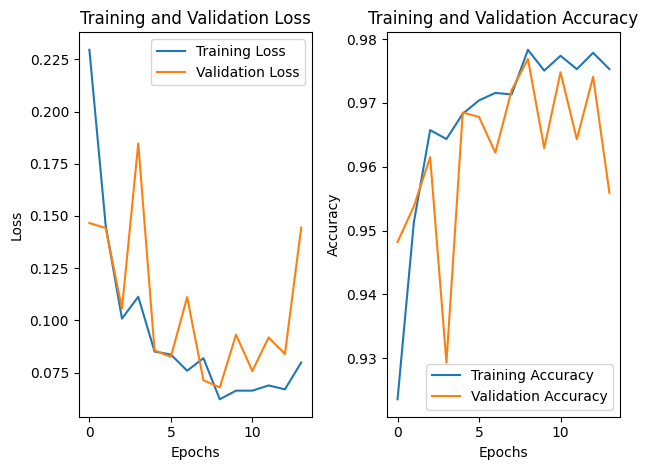

In [29]:
# Plotting the training and validation los

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

In [30]:
class_names = list(val_data.class_indices.keys())

# Get predictions for the validation data
val_predictions = model4.predict(val_data)
y_pred = np.argmax(val_predictions, axis=1)  # Predicted classes
y_true = val_data.classes  # True classes from the generator

1429/1429 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step


In [31]:
print("\nTest Classification Report:")
print(classification_report(y_true, y_pred, target_names=list(test_data.class_indices.keys())))


Test Classification Report:
              precision    recall  f1-score   support

      cloudy       0.99      0.89      0.94       385
      desert       0.88      1.00      0.94       282
  green_area       0.97      0.95      0.96       375
       water       0.94      0.96      0.95       387

    accuracy                           0.95      1429
   macro avg       0.95      0.95      0.95      1429
weighted avg       0.95      0.95      0.95      1429



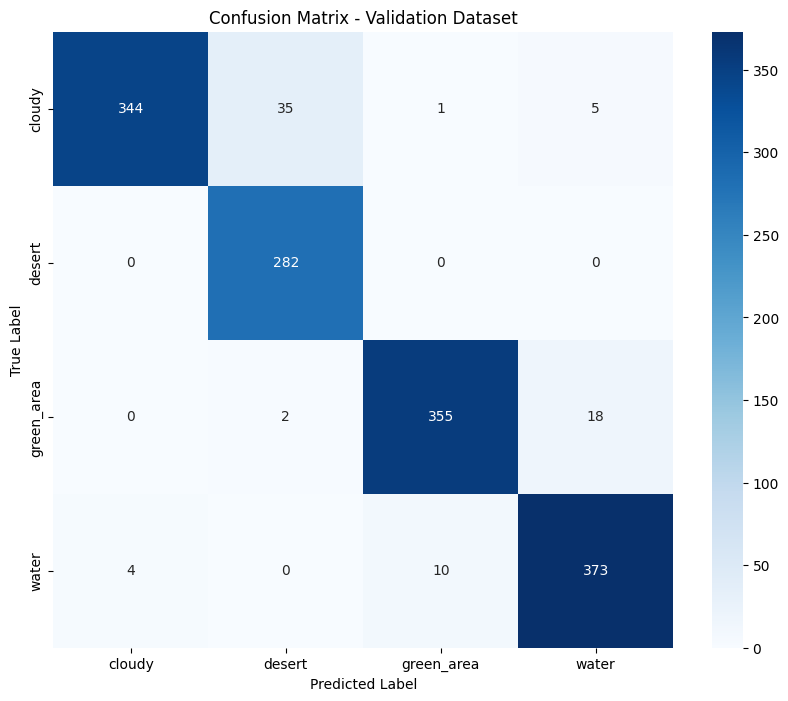

In [32]:
# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)

plt.title('Confusion Matrix - Validation Dataset')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


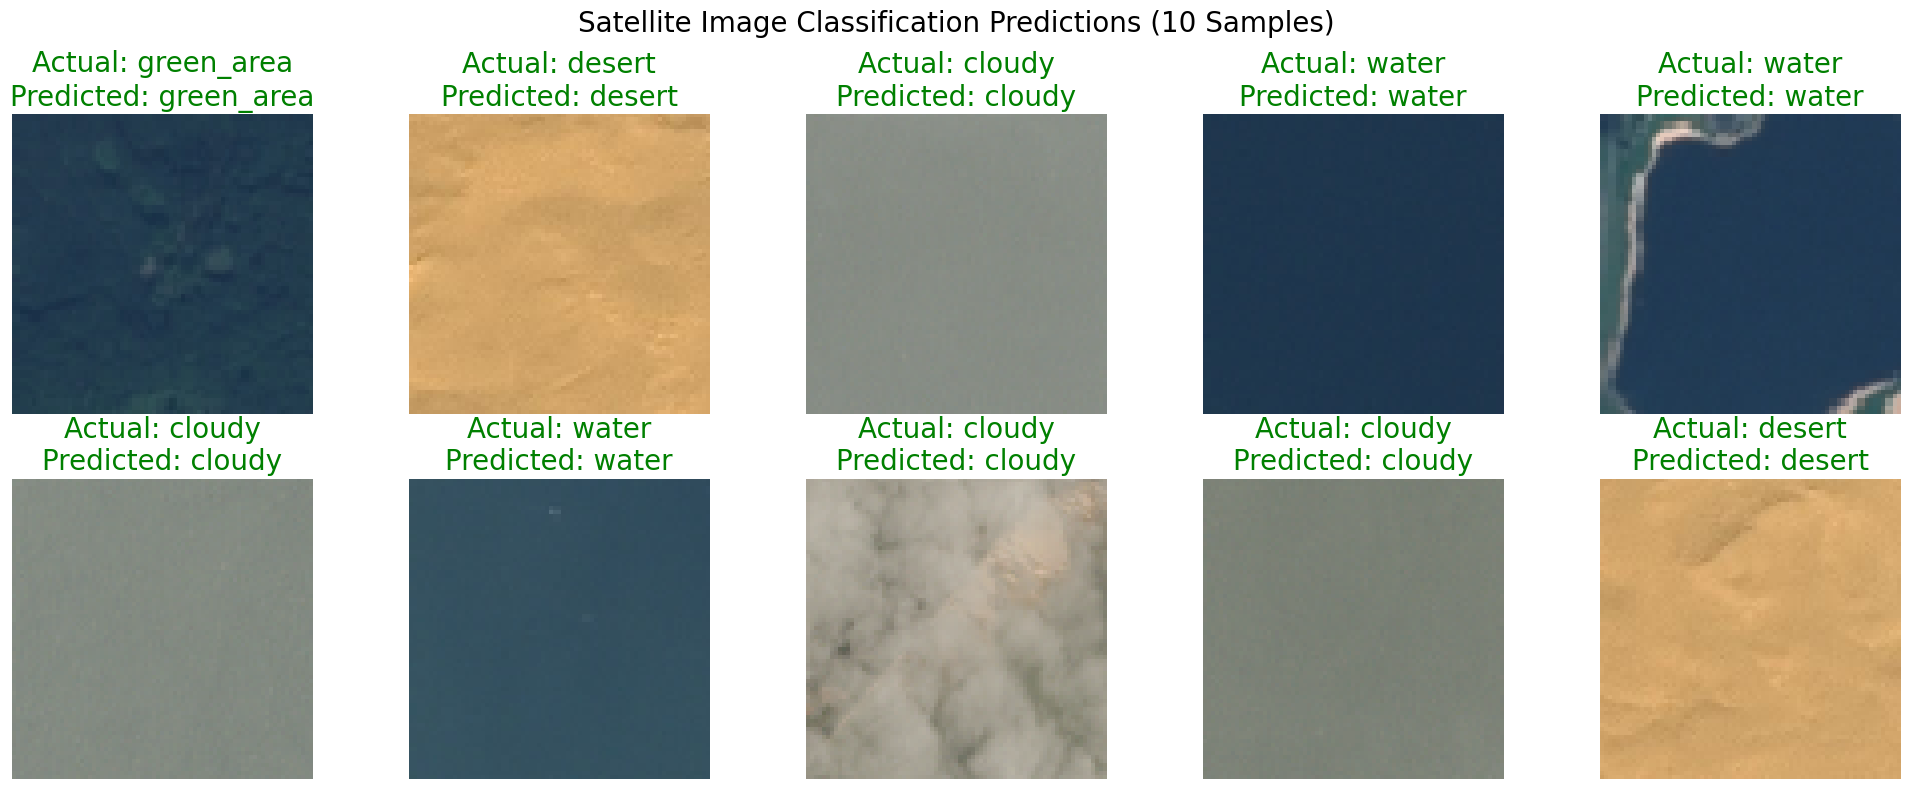

In [33]:
# Get class names from the generator
class_names = list(test_data.class_indices.keys())

num_rows = int(np.ceil(10 / 5))  # Calculate rows dynamically

# Set up the figure size
plt.figure(figsize=(20, 8))

# Extract 10 images and their labels from the test generator
test_images, test_labels = next(test_data)  # Fetch a single batch from test_data
test_images = test_images[:10]
test_labels = test_labels[:10]

# Loop through the samples for display
for i in range(10):
    # Preprocess the image for prediction
    img = test_images[i]  # Already preprocessed by ImageDataGenerator
    true_class = np.argmax(test_labels[i])  # Get the true label
    predicted_class = np.argmax(model4.predict(np.expand_dims(img, axis=0)), axis=-1)  # Predict class
    # Determine if the prediction is correct
    is_correct = true_class == predicted_class[0]
    # Set the color based on whether the prediction is correct
    title_color = 'green' if is_correct else 'red'
    # Display the image
    plt.subplot(num_rows, 5, i + 1)
    plt.imshow(img)  # Image is already scaled between 0 and 1
    plt.title(f"Actual: {class_names[true_class]}\nPredicted: {class_names[predicted_class[0]]}", fontsize = 20, color=title_color)
    plt.axis('off')

# Add a global title
plt.suptitle('Satellite Image Classification Predictions (10 Samples)', fontsize=20)
plt.tight_layout()
plt.subplots_adjust(top=0.85)  # Adjust spacing for the title
plt.show()

In [1]:
pip install opencv-python tensorflow numpy matplotlib
